In [ ]:
# Using the analysis module (recommended approach)
import sys

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

sys.path.append("../src/")
from analysis.statistical import analyze_access_disparity, create_boolean_columns, run_manova
from config.defaults import DEFAULT_TRIP_TIMES

In [2]:
ejblocks = gpd.read_file("../data/joins/ejblocks.shp.zip")

## MANOVA

In [3]:
from statsmodels.multivariate.manova import MANOVA

fit = MANOVA.from_formula(
    "AC_5 + AC_10 + AC_15 + AC_20 + AC_30 + AC_45 + AC_60 ~ TC", data=ejblocks
)
print(fit.mv_test())

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept        Value  Num DF   Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.9795 7.0000 47130.0000 141.2455 0.0000
         Pillai's trace 0.0205 7.0000 47130.0000 141.2455 0.0000
 Hotelling-Lawley trace 0.0210 7.0000 47130.0000 141.2455 0.0000
    Roy's greatest root 0.0210 7.0000 47130.0000 141.2455 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
            TC           Value  Num DF   Den DF   F Value Pr > F
----------------------------------------------------------------
           Wilks' lambda 0.9988 7.0000 47130.0000  8.2736 0.0000
          Pillai's trace 0.0012 7.0000 47130.

## Creating Boolean Columns

In [3]:
cols = ["AC_5", "AC_10", "AC_15", "AC_20", "AC_30", "AC_45", "AC_60"]
cols_bools = [col + "_bool" for col in cols]
cols_pops = [col + "_pop" for col in cols]

In [4]:
ejblocks["TC_bool"] = ejblocks["TC"] > 0
for i in range(len(cols)):
    if i == 0:
        ejblocks[cols_bools[i]] = ejblocks[cols[i]] > 0
    else:
        ejblocks[cols_bools[i]] = (ejblocks[cols[i]] > 0) | ejblocks[cols_bools[i - 1]]
    ejblocks[cols_pops[i]] = np.where(ejblocks[cols_bools[i]], ejblocks["P1_001N"], 0)

In [5]:
ejblocks[cols_bools].head(10)

,AC_5_bool,AC_10_bool,AC_15_bool,AC_20_bool,AC_30_bool,AC_45_bool,AC_60_bool
0,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True
3,False,True,True,True,True,True,True
4,False,True,True,True,True,True,True
5,False,True,True,True,True,True,True
6,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True
9,True,True,True,True,True,True,True


## 10-Minute Walk Analysis

In [7]:
tab = pd.crosstab(
    ejblocks["TC_bool"], np.logical_not(ejblocks["AC_10_bool"]), ejblocks["P1_001N"], aggfunc="sum"
)
table = sm.stats.Table2x2(tab)

print("Total Values:", int(np.sum(tab.values)))
print(table.table_orig)
print(table.summary())
print(table.test_nominal_association())
print("Probability of No Conserved Land w/in 10-Minute Walk:", table.marginal_probabilities[1])

Total Values: 1362359
AC_10_bool     False     True 
AC_10_bool                    
False       257017.0  733056.0
True         77683.0  294603.0
               Estimate   SE   LCB   UCB  p-value
-------------------------------------------------
Odds ratio        1.330       1.318 1.342   0.000
Log odds ratio    0.285 0.005 0.276 0.294   0.000
Risk ratio        1.244       1.235 1.253   0.000
Log risk ratio    0.218 0.004 0.211 0.225   0.000
-------------------------------------------------
df          1
pvalue      0.0
statistic   3786.722929514167
Probability of No Conserved Land w/in 10-Minute Walk: AC_10_bool
False    0.245677
True     0.754323
dtype: float64


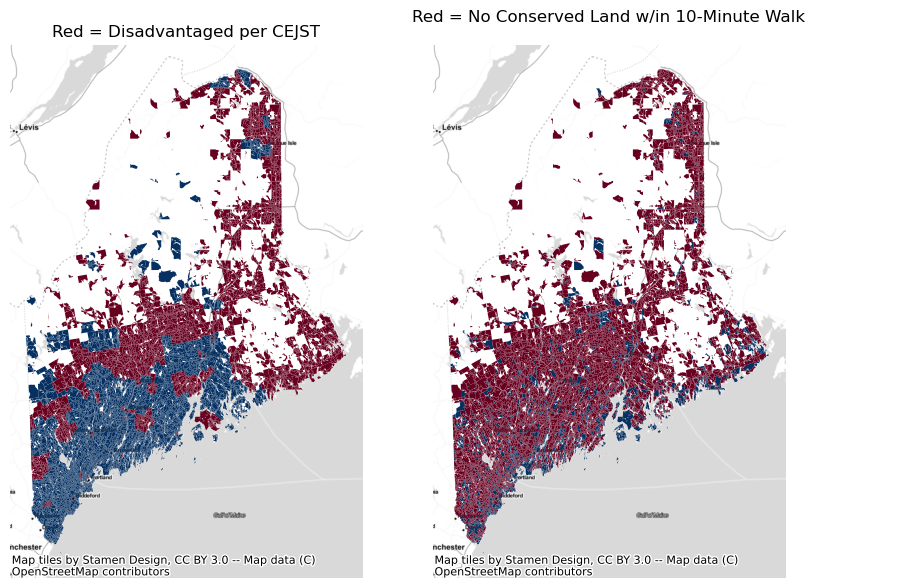

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
ejblocks[ejblocks["P1_001N"] > 0].plot("TC_bool", cmap="RdBu_r", ax=axs[0])
ejblocks[ejblocks["P1_001N"] > 0].plot("AC_10_bool", cmap="RdBu", ax=axs[1])
axs[0].set_title("Red = Disadvantaged per CEJST")
axs[1].set_title("Red = No Conserved Land w/in 10-Minute Walk")
axs[0].axis("off")
axs[1].axis("off")
cx.add_basemap(axs[0], source=cx.providers.Stamen.TonerLite)
cx.add_basemap(axs[1], source=cx.providers.Stamen.TonerLite)

## 60-Minute Walk Analysis

In [9]:
tab = pd.crosstab(
    ejblocks["TC_bool"], np.logical_not(ejblocks["AC_60_bool"]), ejblocks["P1_001N"], aggfunc="sum"
)
table = sm.stats.Table2x2(tab)

print("Total Values:", int(np.sum(tab.values)))
print(table.table_orig)
print(table.summary())
print(table.test_nominal_association())
print(*table.marginal_probabilities)
print("Probability of No Conserved Land w/in 60-Minute Walk:", table.marginal_probabilities[1])

Total Values: 1362359
AC_60_bool     False     True 
AC_60_bool                    
False       896336.0   93737.0
True        271449.0  100837.0
               Estimate   SE   LCB   UCB  p-value
-------------------------------------------------
Odds ratio        3.552       3.517 3.587   0.000
Log odds ratio    1.268 0.005 1.258 1.277   0.000
Risk ratio        1.242       1.239 1.244   0.000
Log risk ratio    0.216 0.001 0.214 0.218   0.000
-------------------------------------------------
df          1
pvalue      0.0
statistic   68597.98863767541
AC_60_bool
False    0.726734
True     0.273266
dtype: float64 AC_60_bool
False    0.857179
True     0.142821
dtype: float64
Probability of No Conserved Land w/in 60-Minute Walk: AC_60_bool
False    0.857179
True     0.142821
dtype: float64


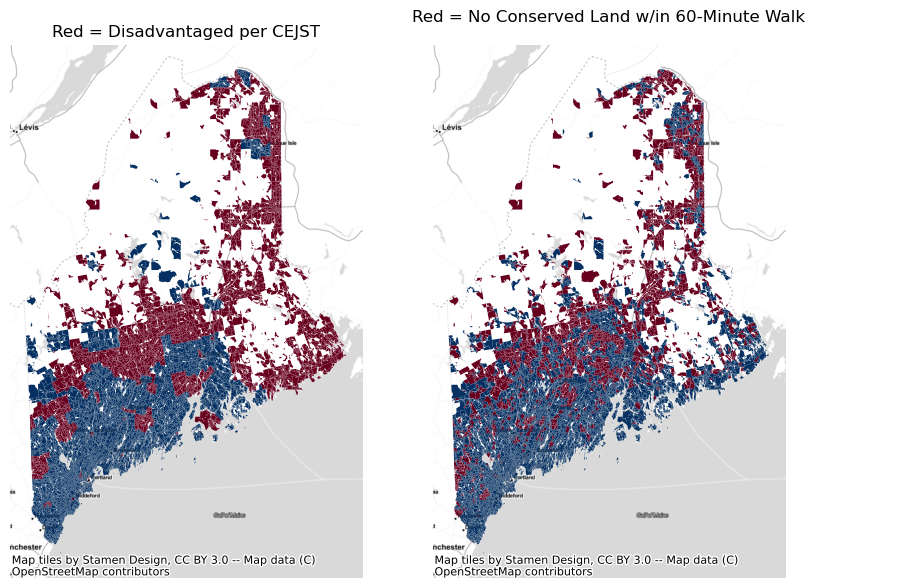

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
ejblocks[ejblocks["P1_001N"] > 0].plot("TC_bool", cmap="RdBu_r", ax=axs[0])
ejblocks[ejblocks["P1_001N"] > 0].plot("AC_60_bool", cmap="RdBu", ax=axs[1])
axs[0].set_title("Red = Disadvantaged per CEJST")
axs[1].set_title("Red = No Conserved Land w/in 60-Minute Walk")
axs[0].axis("off")
axs[1].axis("off")
cx.add_basemap(axs[0], source=cx.providers.Stamen.TonerLite)
cx.add_basemap(axs[1], source=cx.providers.Stamen.TonerLite)

## Checking Population and Population Density Effects

## Using the analysis module

The code above shows the original implementation. Below is an example using the `analysis.statistical` module:


In [ ]:
# Example using the analysis.statistical module
cols = [f"AC_{t}" for t in DEFAULT_TRIP_TIMES]
ejblocks_module = create_boolean_columns(ejblocks, cols)

# Run MANOVA
fit_module = run_manova(ejblocks_module, dependent_vars=cols, independent_var="TC")
print(fit_module.mv_test())

# Analyze access disparity
tab_module, table_module = analyze_access_disparity(
    ejblocks_module, access_col="AC_10_bool", disadvantage_col="TC_bool"
)
print(table_module.summary())

In [11]:
fit = MANOVA.from_formula(
    "AC_10 + AC_60 ~ TC + P1_001N + POPDENSE + TC*POPDENSE + TC*P1_001N", data=ejblocks
)
print(fit.mv_test())

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept        Value  Num DF   Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.9939 2.0000 43172.0000 132.8277 0.0000
         Pillai's trace 0.0061 2.0000 43172.0000 132.8277 0.0000
 Hotelling-Lawley trace 0.0062 2.0000 43172.0000 132.8277 0.0000
    Roy's greatest root 0.0062 2.0000 43172.0000 132.8277 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
            TC           Value  Num DF   Den DF   F Value Pr > F
----------------------------------------------------------------
           Wilks' lambda 0.9993 2.0000 43172.0000 15.9424 0.0000
          Pillai's trace 0.0007 2.0000 43172.